## Import the libraries/packages we will need

In [1]:
import pickle  #for saving/loading data
import numpy as np  #for dealing with numbers
from sklearn.model_selection import train_test_split  #for crossvalidation
from sklearn.linear_model import LogisticRegressionCV  #Logistic regression maching learning model
from keras.models import Sequential  #keras sequential deep learning model
from keras.layers import Dense, Activation, Dropout, Conv1D, Flatten, MaxPooling1D #various deep learning tools
from keras.utils import np_utils, plot_model #utilities, plots the network
from sklearn.preprocessing import StandardScaler #for scaling the data
import seaborn as sns #for making nice plots
import matplotlib.pyplot as plt  #for plotting


/home/pestillilab/anaconda2/envs/tf1.4py2.7/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load the data
Here we are loading in data that has already been preprocessed in python and saved down using pickle

In [2]:
tractev_dict_600 = pickle.load(open("tract_ev_dict_600.pk",'rb'))
tractstouse = pickle.load(open('tractstouse.pk','rb'))
HCP_subj_list = pickle.load(open('HCP_subj_list.pk','rb'))
gender_id = pickle.load(open('gender_id.pk','rb'))


We have a dictionary with entries for each tract. The tract entires contain one row per subject and one column per eigenvalue. We have 600 eigenvalues to work with per tract.

In [3]:
tractev_dict_600.keys()[0:5] #get the first five keys of the dictionary

['Left_TPC_surf',
 'Left_Cingulum3_surf',
 'Left_IFOF_surf',
 'Right_ILF_surf',
 'Left_anterior_thalamic_surf']

We also have a list of all the tracts we want to use (48 in total).

In [4]:
print len(tractstouse) #print out the length/number of entries in the list
tractstouse[0:5] # print out the first five entries

48


['Corpus_Callosum_surf',
 'Forceps_Major_surf',
 'Forceps_Minor_surf',
 'Left_Arcuate_surf',
 'Left_Aslant_surf']

In [5]:
tractev_dict_600[tractstouse[0]].shape #get the shape of the array

(1013, 600)

We can see by the shape of the dictionary entry for the first tract we will use that we have 1013 subjects and 600 eigenvalues. This entry is a 1013 by 600 array.

We also have a list of the ids of the subjects we will be using

In [6]:
print len(HCP_subj_list)
HCP_subj_list[0:5]

1013


['100206', '100307', '100408', '100610', '101006']

Lastly, we have a list of the gender of each subject. Males = 1, Females = 2

In [7]:
print len(gender_id)
gender_id[0:5]

1013


[1, 2, 1, 1, 2]

We can see that subject 100206 is male and subject 100307 is female. 

## Scale the eigenvalues

We need to scale the eigenvalues to be centered around 0 to be sure that no eigenvalue is weighted higher than another. We will work with a single tract for now

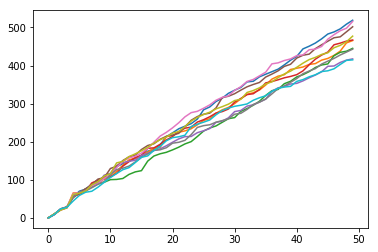

In [8]:
# plot the first 50 eigenvalues of 10 subjects to see how the data looks originally
%matplotlib inline 
#ensures the plots are shown in the notebook
for i in range(10):
    plt.plot(tractev_dict_600[tractstouse[0]][i][0:50])
plt.show()

In [9]:
# function to scale the data

def scale_evs(ev_dict):
    scaler = StandardScaler()
    scaled_evs = scaler.fit_transform(ev_dict)
    return scaled_evs

In [10]:

#scale the eigenvalues of a single tract
scaled_tract = scale_evs(tractev_dict_600[tractstouse[0]])

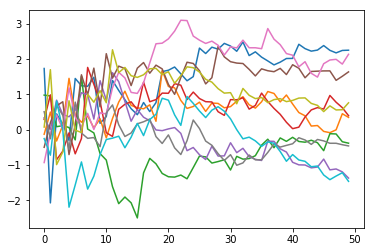

In [11]:
for i in range(10):
    plt.plot(scaled_tract[i][0:50])
plt.show()

The relationships in the data are preserved, the data is just shifted down to center on 0.

## Baseline test with Logistic Regression classifier
We are going to first classify the data using a simple logistic regression classifier to give us a baseline to compare the deep learning results to.

In [12]:
X = scaled_tract
Y = gender_id

# split the data 80/20 for cross validation
trainX, testX, trainY, testY = train_test_split(X, Y, train_size  = .8, test_size = .2, random_state=0)

# train the algorithm
lr = LogisticRegressionCV()
lr.fit(trainX, trainY)

# test the accuracy
print("Accuracy = {:.2f}".format(lr.score(testX, testY)))


Accuracy = 0.67


## Deep Learning with Keras

Now lets try a neural network. We will test two different types of neural networks: fully connected and convolutional. We will start with the fully connected. 

### prepare the labels for deep learning
deep learning requires the labels be one hot encoded so we need tchange ours labels

In [13]:

def one_hot_encode_object_array(arr):
    uniques, ids = np.unique(arr, return_inverse=True)
    return np_utils.to_categorical(ids, len(uniques))


In [14]:

trainYbin = np.zeros(len(trainY))
for i in range(len(trainY)):
    if trainY[i] == 2:
        trainYbin[i]=1

testYbin = np.zeros(len(testY))
for i in range(len(testY)):
    if testY[i] == 2:
        testYbin[i]=1

trainY_onehot = one_hot_encode_object_array(np.array(trainY))
testY_onehot = one_hot_encode_object_array(np.array(testY))


In [16]:

model = Sequential()
model.add(Dense(350,input_dim=600, activation='relu'))
model.add(Dropout(0.5))
#model.add(Activation('sigmoid'))
model.add(Dense(150, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(75, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
#model.add(Activation('softmax'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(trainX, trainYbin, epochs=100, batch_size=5)

loss, accuracy = model.evaluate(testX, testYbin, verbose=0)
print("Accuracy = {:.2f}".format(accuracy))


Epoch 1/100
810/810 [==============================] - 2s 2ms/step - loss: 1.3388 - acc: 0.5617
Epoch 2/100
810/810 [==============================] - 1s 941us/step - loss: 1.1508 - acc: 0.5346
Epoch 3/100
810/810 [==============================] - 1s 924us/step - loss: 0.9583 - acc: 0.5593
Epoch 4/100
810/810 [==============================] - 1s 934us/step - loss: 0.9076 - acc: 0.5506
Epoch 5/100
810/810 [==============================] - 1s 942us/step - loss: 0.7840 - acc: 0.5531
Epoch 6/100
810/810 [==============================] - 1s 924us/step - loss: 0.7247 - acc: 0.5852
Epoch 7/100
810/810 [==============================] - 1s 916us/step - loss: 0.7330 - acc: 0.5630
Epoch 8/100
810/810 [==============================] - 1s 933us/step - loss: 0.7362 - acc: 0.5506
Epoch 9/100
810/810 [==============================] - 1s 940us/step - loss: 0.6885 - acc: 0.5679
Epoch 10/100
810/810 [==============================] - 1s 931us/step - loss: 0.6860 - acc: 0.5938
Epoch 11/100
810/810 

KeyboardInterrupt: 